In [4]:
%matplotlib inline
import os,random
from packaging import version
import datetime
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import _pickle as cPickle
%load_ext tensorboard
import numpy as np
print("TensorFlow version: ", tf.__version__)
assert version.parse(tf.__version__).release[0] >= 2, \
    "This notebook requires TensorFlow 2.0 or above."

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
TensorFlow version:  2.2.0


In [2]:
logdir = "logs/scalars/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

In [3]:
Xd = cPickle.load(open("RML2016.10a_dict.pkl",'rb'), encoding='latin1')
snrs,mods = map(lambda j: sorted(list(set(map(lambda x: x[j], Xd.keys())))), [1,0])
X = []  
lbl = []
for mod in mods:
    for snr in snrs:
        X.append(Xd[(mod,snr)])
        for i in range(Xd[(mod,snr)].shape[0]):  lbl.append((mod,snr))
X = np.vstack(X)

In [4]:
np.random.seed(2016)
n_examples = X.shape[0]
n_train = n_examples * 0.5
train_idx = np.random.choice(range(0,int(n_examples)), size=int(n_train), replace=False)
test_idx = list(set(range(0,n_examples))-set(train_idx))
X_train = X[train_idx]
X_test =  X[test_idx]
def to_onehot(yy):
    yy1 = np.zeros([len(yy), max(yy)+1])
    yy1[np.arange(len(yy)),yy] = 1
    return yy1
Y_train = to_onehot(list(map(lambda x: mods.index(lbl[x][0]), train_idx)))
Y_test = to_onehot(list(map(lambda x: mods.index(lbl[x][0]), test_idx)))

In [5]:
in_shp = list(X_train.shape[1:])
classes = mods

In [6]:
in_shp = list(X_train.shape[1:])
classes = mods
dr = 0.5 # dropout rate (%)
model = tf.keras.Sequential()
model.add(tf.keras.layers.Reshape(([1]+in_shp), input_shape=in_shp))
model.add(tf.keras.layers.ZeroPadding2D((0, 2), data_format="channels_first"))
model.add(tf.keras.layers.Convolution2D(256, (1, 3), padding='valid', activation="relu", name="conv1", kernel_initializer=tf.keras.initializers.GlorotUniform(), data_format="channels_first"))
model.add(tf.keras.layers.Dropout(dr))
model.add(tf.keras.layers.ZeroPadding2D((0, 2), data_format="channels_first"))
model.add(tf.keras.layers.Convolution2D(80, (2, 3), padding='valid', activation="relu", name="conv2", kernel_initializer=tf.keras.initializers.GlorotUniform(), data_format="channels_first"))
model.add(tf.keras.layers.Dropout(dr))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(256, activation='relu', kernel_initializer=tf.keras.initializers.he_normal(), name="dense1"))
model.add(tf.keras.layers.Dropout(dr))
model.add(tf.keras.layers.Dense( len(classes), kernel_initializer=tf.keras.initializers.he_normal(), name="dense2" ))
model.add(tf.keras.layers.Activation('softmax'))
model.add(tf.keras.layers.Reshape([len(classes)]))
model.compile(loss='categorical_crossentropy', optimizer='adam')
model.summary()
#CNN2 here

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 1, 2, 128)         0         
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 1, 2, 132)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 256, 2, 130)       1024      
_________________________________________________________________
dropout (Dropout)            (None, 256, 2, 130)       0         
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 256, 2, 134)       0         
_________________________________________________________________
conv2 (Conv2D)               (None, 80, 1, 132)        122960    
_________________________________________________________________
dropout_1 (Dropout)          (None, 80, 1, 132)        0

In [7]:
nb_epoch = 100  
batch_size = 1024 

In [9]:
filepath = "convmodrecnets_CNN2_0.5.wts.h5"
score = model.fit(X_train, Y_train, 
                  verbose = 2, 
                  validation_data = (X_test, Y_test), 
                  epochs=100, 
                  batch_size=batch_size,
                  callbacks = [
                      tensorboard_callback,
                      tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True, mode='auto'),
                      tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='auto')
                  ]
                 )
model.load_weights(filepath)


Epoch 1/100
108/108 - 6s - loss: 1.3254 - val_loss: 1.3043
Epoch 2/100
108/108 - 5s - loss: 1.3231 - val_loss: 1.3021
Epoch 3/100
108/108 - 5s - loss: 1.3200 - val_loss: 1.2886
Epoch 4/100
108/108 - 5s - loss: 1.3192 - val_loss: 1.2808
Epoch 5/100
108/108 - 5s - loss: 1.3132 - val_loss: 1.2843
Epoch 6/100
108/108 - 5s - loss: 1.3112 - val_loss: 1.2837
Epoch 7/100
108/108 - 5s - loss: 1.3070 - val_loss: 1.2910
Epoch 8/100
108/108 - 5s - loss: 1.3054 - val_loss: 1.2716
Epoch 9/100
108/108 - 5s - loss: 1.3015 - val_loss: 1.2727
Epoch 10/100
108/108 - 5s - loss: 1.3022 - val_loss: 1.2824
Epoch 11/100
108/108 - 5s - loss: 1.2996 - val_loss: 1.2823
Epoch 12/100
108/108 - 5s - loss: 1.2942 - val_loss: 1.3114
Epoch 13/100
108/108 - 5s - loss: 1.2927 - val_loss: 1.2702
Epoch 14/100
108/108 - 5s - loss: 1.2895 - val_loss: 1.2750
Epoch 15/100
108/108 - 5s - loss: 1.2915 - val_loss: 1.2754
Epoch 16/100
108/108 - 5s - loss: 1.2851 - val_loss: 1.2698
Epoch 17/100
108/108 - 5s - loss: 1.2857 - val_lo

In [10]:
score = model.evaluate(X_test, Y_test, verbose=0, batch_size=batch_size)
print(score)

1.2697771787643433


Overall Accuracy:  0.09643183897529735
Overall Accuracy:  0.09118982742960945
Overall Accuracy:  0.0956946454413893
Overall Accuracy:  0.11277517141826056
Overall Accuracy:  0.14421148587055607
Overall Accuracy:  0.22942953616491915
Overall Accuracy:  0.3512768693735073
Overall Accuracy:  0.4968841642228739
Overall Accuracy:  0.6046210720887246
Overall Accuracy:  0.6667271407837445
Overall Accuracy:  0.7129562043795621
Overall Accuracy:  0.7159214830970556
Overall Accuracy:  0.7327459618208517
Overall Accuracy:  0.7368231046931408
Overall Accuracy:  0.7305680793507665
Overall Accuracy:  0.7460837887067395
Overall Accuracy:  0.726054680427304
Overall Accuracy:  0.7338992434028418
Overall Accuracy:  0.7234389140271493
Overall Accuracy:  0.7344734473447345


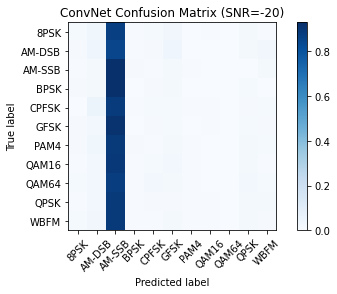

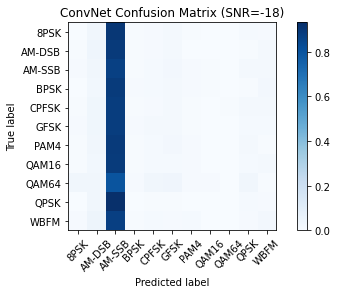

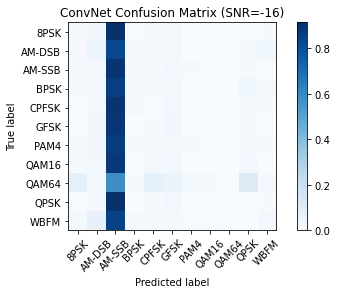

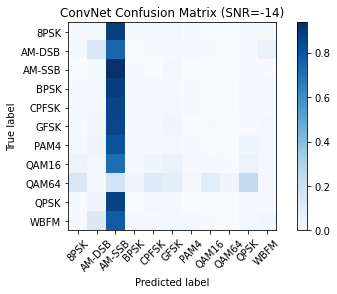

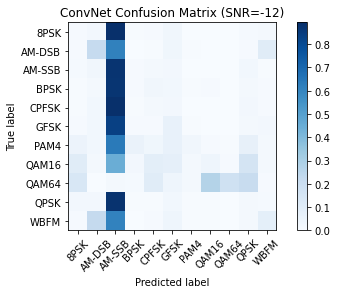

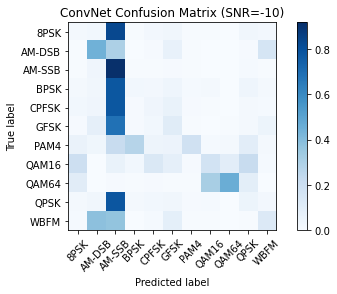

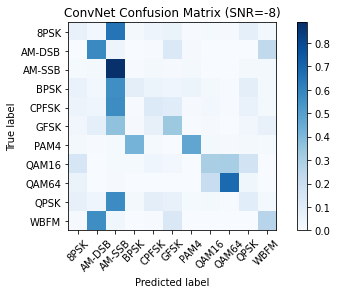

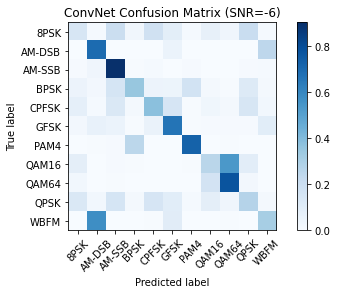

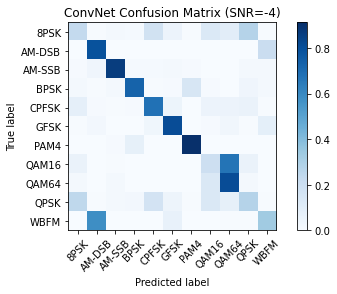

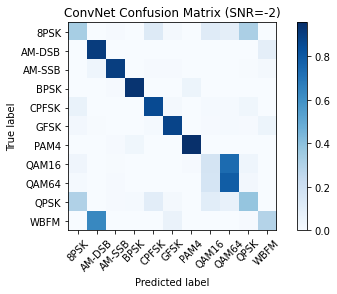

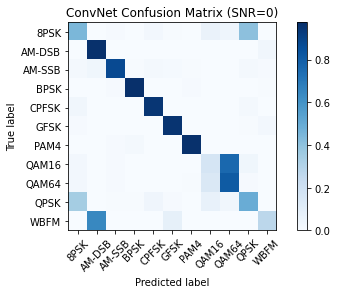

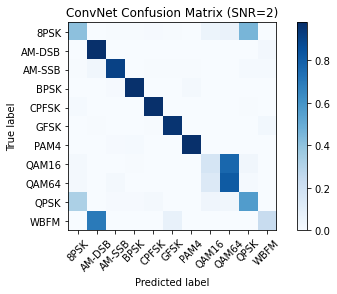

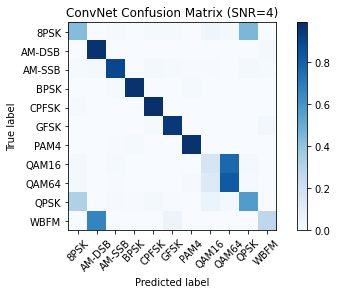

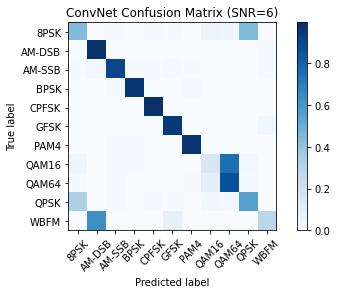

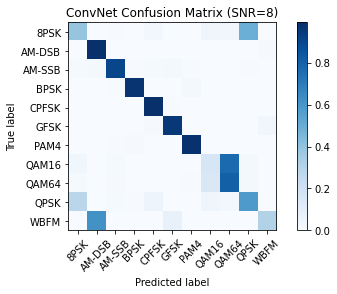

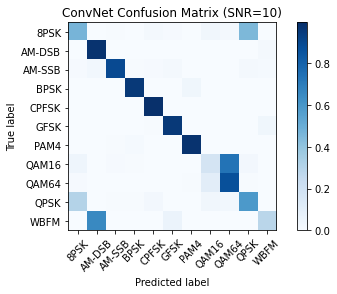

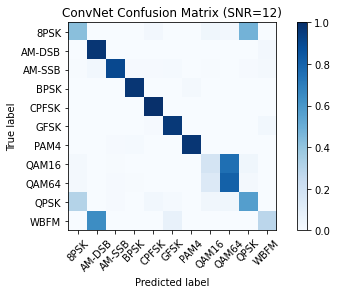

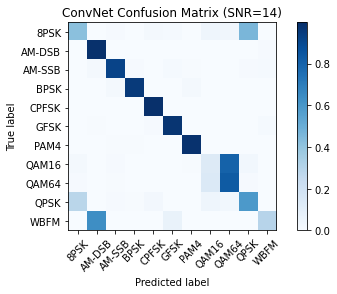

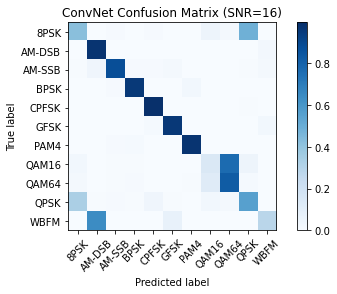

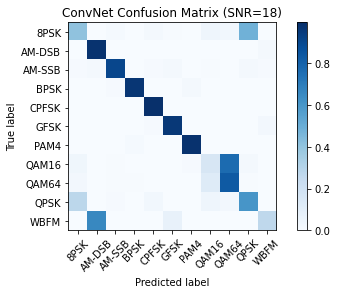

In [15]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, labels=[]):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
acc = {}
for snr in snrs:
    # extract classes @ SNR
    test_SNRs = list(map(lambda x: lbl[x][1], test_idx))
#    print(test_SNRs)
    test_X_i = X_test[np.where(np.array(test_SNRs)==snr)]
    test_Y_i = Y_test[np.where(np.array(test_SNRs)==snr)]    
    test_Y_i_hat = model.predict(test_X_i)
    conf = np.zeros([len(classes),len(classes)])
    confnorm = np.zeros([len(classes),len(classes)])
    for i in range(0,test_X_i.shape[0]):
        j = list(test_Y_i[i,:]).index(1)
        k = int(np.argmax(test_Y_i_hat[i,:]))
        conf[j,k] = conf[j,k] + 1
    for i in range(0,len(classes)):
        confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
    plt.figure()
    plot_confusion_matrix(confnorm, labels=classes, title="ConvNet Confusion Matrix (SNR=%d)"%(snr))
    
    cor = np.sum(np.diag(conf))
    ncor = np.sum(conf) - cor
    print ("Overall Accuracy: ", cor / (cor+ncor))
    acc[snr] = 1.0*cor/(cor+ncor)



Text(0.5, 1.0, 'CNN2 Classification Accuracy on RadioML 2016.10 Alpha')

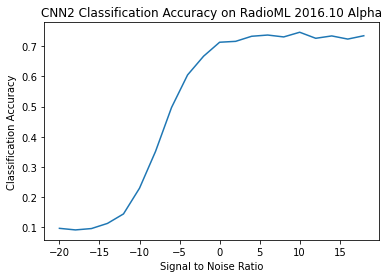

In [16]:
plt.plot(snrs, list(map(lambda x: acc[x], snrs)))
plt.xlabel("Signal to Noise Ratio")
plt.ylabel("Classification Accuracy")
plt.title("CNN2 Classification Accuracy on RadioML 2016.10 Alpha")

In [27]:
acc = {}
for i in snrs:
    acc[i] = []

In [28]:
def runner(seed):
    np.random.seed(seed)
    nb_epoch = 100  
    batch_size = 1024 
    n_examples = X.shape[0]
    n_train = n_examples * 0.5
    train_idx = np.random.choice(range(0,int(n_examples)), size=int(n_train), replace=False)
    test_idx = list(set(range(0,n_examples))-set(train_idx))
    X_train = X[train_idx]
    X_test =  X[test_idx]
    def to_onehot(yy):
        yy1 = np.zeros([len(yy), max(yy)+1])
        yy1[np.arange(len(yy)),yy] = 1
        return yy1
    Y_train = to_onehot(list(map(lambda x: mods.index(lbl[x][0]), train_idx)))
    Y_test = to_onehot(list(map(lambda x: mods.index(lbl[x][0]), test_idx)))
    in_shp = list(X_train.shape[1:])
    classes = mods
    dr = 0.5 # dropout rate (%)
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Reshape(([1]+in_shp), input_shape=in_shp))
    model.add(tf.keras.layers.ZeroPadding2D((0, 2), data_format="channels_first"))
    model.add(tf.keras.layers.Convolution2D(256, (1, 3), padding='valid', activation="relu", name="conv1", kernel_initializer=tf.keras.initializers.GlorotUniform(), data_format="channels_first"))
    model.add(tf.keras.layers.Dropout(dr))
    model.add(tf.keras.layers.ZeroPadding2D((0, 2), data_format="channels_first"))
    model.add(tf.keras.layers.Convolution2D(80, (2, 3), padding='valid', activation="relu", name="conv2", kernel_initializer=tf.keras.initializers.GlorotUniform(), data_format="channels_first"))
    model.add(tf.keras.layers.Dropout(dr))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(256, activation='relu', kernel_initializer=tf.keras.initializers.he_normal(), name="dense1"))
    model.add(tf.keras.layers.Dropout(dr))
    model.add(tf.keras.layers.Dense( len(classes), kernel_initializer=tf.keras.initializers.he_normal(), name="dense2" ))
    model.add(tf.keras.layers.Activation('softmax'))
    model.add(tf.keras.layers.Reshape([len(classes)]))
    model.compile(loss='categorical_crossentropy', optimizer='adam')
#     model.summary()
    filepath = "convmodrecnets_CNN2_0.5.wts_%d.h5"%(seed)
    score = model.fit(X_train, Y_train, 
                      verbose = 2, 
                      validation_data = (X_test, Y_test), 
                      epochs=100, 
                      batch_size=batch_size,
                      callbacks = [
                          tensorboard_callback,
                          tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True, mode='auto'),
                          tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='auto')
                      ]
                     )
    model.load_weights(filepath)
    for snr in snrs:
        # extract classes @ SNR
        test_SNRs = list(map(lambda x: lbl[x][1], test_idx))
    #    print(test_SNRs)
        test_X_i = X_test[np.where(np.array(test_SNRs)==snr)]
        test_Y_i = Y_test[np.where(np.array(test_SNRs)==snr)]    
        test_Y_i_hat = model.predict(test_X_i)
        conf = np.zeros([len(classes),len(classes)])
        confnorm = np.zeros([len(classes),len(classes)])
        for i in range(0,test_X_i.shape[0]):
            j = list(test_Y_i[i,:]).index(1)
            k = int(np.argmax(test_Y_i_hat[i,:]))
            conf[j,k] = conf[j,k] + 1
        for i in range(0,len(classes)):
            confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
#         plt.figure()
#         plot_confusion_matrix(confnorm, labels=classes, title="ConvNet Confusion Matrix (SNR=%d)"%(snr))
        cor = np.sum(np.diag(conf))
        ncor = np.sum(conf) - cor
        accuracy = cor / (cor+ncor)
        print ("Overall Accuracy: ", accuracy)
        acc[snr].append(accuracy)

for i in [1947, 1971, 1977, 1999, 2020]:
    runner(i)

Epoch 1/100
108/108 - 6s - loss: 2.2564 - val_loss: 2.1072
Epoch 2/100
108/108 - 5s - loss: 2.0238 - val_loss: 1.8875
Epoch 3/100
108/108 - 5s - loss: 1.8733 - val_loss: 1.7528
Epoch 4/100
108/108 - 5s - loss: 1.7639 - val_loss: 1.6537
Epoch 5/100
108/108 - 5s - loss: 1.6952 - val_loss: 1.5870
Epoch 6/100
108/108 - 5s - loss: 1.6456 - val_loss: 1.5475
Epoch 7/100
108/108 - 5s - loss: 1.6063 - val_loss: 1.4917
Epoch 8/100
108/108 - 5s - loss: 1.5594 - val_loss: 1.4655
Epoch 9/100
108/108 - 5s - loss: 1.5171 - val_loss: 1.3940
Epoch 10/100
108/108 - 5s - loss: 1.4919 - val_loss: 1.3816
Epoch 11/100
108/108 - 5s - loss: 1.4696 - val_loss: 1.3601
Epoch 12/100
108/108 - 5s - loss: 1.4594 - val_loss: 1.3553
Epoch 13/100
108/108 - 5s - loss: 1.4539 - val_loss: 1.3461
Epoch 14/100
108/108 - 5s - loss: 1.4394 - val_loss: 1.3539
Epoch 15/100
108/108 - 5s - loss: 1.4266 - val_loss: 1.3305
Epoch 16/100
108/108 - 5s - loss: 1.4211 - val_loss: 1.3183
Epoch 17/100
108/108 - 5s - loss: 1.4096 - val_lo

Epoch 30/100
108/108 - 5s - loss: 1.3323 - val_loss: 1.2866
Epoch 31/100
108/108 - 5s - loss: 1.3315 - val_loss: 1.2898
Epoch 32/100
108/108 - 5s - loss: 1.3261 - val_loss: 1.2812
Overall Accuracy:  0.09550460371908287
Overall Accuracy:  0.09657875980042765
Overall Accuracy:  0.09022140221402214
Overall Accuracy:  0.10690025026814444
Overall Accuracy:  0.1181702668360864
Overall Accuracy:  0.20173692780893795
Overall Accuracy:  0.31951798429797335
Overall Accuracy:  0.5027372262773723
Overall Accuracy:  0.6217248908296943
Overall Accuracy:  0.6712527154236061
Overall Accuracy:  0.7159195720346799
Overall Accuracy:  0.7265753424657534
Overall Accuracy:  0.726160029229083
Overall Accuracy:  0.7289232428545749
Overall Accuracy:  0.7266121707538601
Overall Accuracy:  0.7346195850018201
Overall Accuracy:  0.7290334368719167
Overall Accuracy:  0.7371011850501368
Overall Accuracy:  0.7208287895310797
Overall Accuracy:  0.7296500920810313
Epoch 1/100
108/108 - 6s - loss: 2.2522 - val_loss: 2.1

In [57]:
acc

{-20: [0.09992771955186122,
  0.10235934664246824,
  0.09550460371908287,
  0.09306137315607357,
  0.0908764367816092],
 -18: [0.08991268809214192,
  0.09380142622051563,
  0.09657875980042765,
  0.0916320260256642,
  0.09618543529841211],
 -16: [0.09606906686260103,
  0.09248449470995987,
  0.09022140221402214,
  0.09926605504587156,
  0.09772809231878832],
 -14: [0.10879883169039796,
  0.11236155769917827,
  0.10690025026814444,
  0.10650994575045208,
  0.10607168983174835],
 -12: [0.14342058085335246,
  0.12798541476754785,
  0.1181702668360864,
  0.13541291020555354,
  0.13315460232350312],
 -10: [0.2353263850795392,
  0.20181983621474067,
  0.20173692780893795,
  0.21306347746090157,
  0.20949052786463124],
 -8: [0.3583271923360354,
  0.3226101261195394,
  0.31951798429797335,
  0.3214942951785057,
  0.3302514792899408],
 -6: [0.5020094994519547,
  0.48635281187030593,
  0.5027372262773723,
  0.4910649161196207,
  0.49186917595468665],
 -4: [0.6057276657060519,
  0.620221054538865

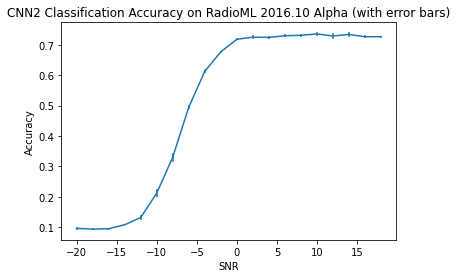

In [60]:
import matplotlib.pyplot as plt

yerr = []
y = []
x = []
for i in acc:
    yerr.append(np.std(acc[i]))
    y.append(np.mean(acc[i]))
    x.append(i)
# plt.errorbar(x, y, yerr, linestyle='solid', marker='^')
fig, ax = plt.subplots()
ax.errorbar(x, y,
#             xerr=xerr,
            yerr=yerr,
            fmt='-')

ax.set_xlabel('SNR')
ax.set_ylabel('Accuracy')
ax.set_title('CNN2 Classification Accuracy on RadioML 2016.10 Alpha (with error bars)')
plt.show()

In [62]:
!conda env export > environment.yml